Una serie temporal es un conjunto de muestras tomadas a intervalos de tiempo regulares. Es interesante analizar su comportamiento al mediano y largo plazo, intentando detectar patrones y poder hacer pronósticos de cómo será su comportamiento futuro

* Es dependiente del Tiempo. Esto rompe con el requerimiento que tiene la regresión lineal de que sus observaciones sean independientes.
* Suelen tener algún tipo de estacionalidad, ó de tendencias a crecer ó decrecer.

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importamos las Librerías**

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

df_2016 = pd.read_csv('/content/drive/MyDrive/2. TP Inteligencia Artificial/Conteo por dia de rayos /conteo_diario_2016.csv')
df_2017 = pd.read_csv('/content/drive/MyDrive/2. TP Inteligencia Artificial/Conteo por dia de rayos /conteo_diario_2017.csv')
df_2018 = pd.read_csv('/content/drive/MyDrive/2. TP Inteligencia Artificial/Conteo por dia de rayos /conteo_diario_2018.csv')

# Concatenar los DataFrames en uno solo
df = pd.concat([df_2016, df_2017, df_2018], ignore_index=True)

In [64]:
df.head()

,timestamp,count
0,2016-01-01,88501
1,2016-01-02,142019
2,2016-01-03,88345
3,2016-01-04,161770
4,2016-01-05,160750


In [65]:
# Convertir la columna de fecha a un índice de fecha/hora
df = df.set_index('timestamp')


# **Preprocesado de los datos**

Usaremos una arquitectura sencilla de red neuronal FeedForward (también llamada MLP por sus siglas Multi-Layered Perceptron), con pocas neuronas y como método de activación tangente hiperbólica pues entregaremos valores transformados entre -1 y 1.

Tomamos nuestra serie temporal y la convertiremos en un “problema de tipo supervisado“ para poder alimentar nuestra red neuronal y poder entrenarla con backpropagation. Tomar los 7 días previos para “obtener” el octavo

In [146]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [157]:
PASOS=7
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    #df.drop(columns=['departamento'], inplace=True)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1)) # MinMaxScaler para transformar el
#rango de nuestros valores entre -1 y 1 (pues sabemos que a nuestra red neuronal,
#le favorece para realizar los cálculos).
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.700785,-0.519843,-0.701312,-0.453066,-0.456514,-0.835854,-0.944393,-0.756375
8,-0.519843,-0.701312,-0.453066,-0.456514,-0.835854,-0.944393,-0.756375,-0.847640
9,-0.701312,-0.453066,-0.456514,-0.835854,-0.944393,-0.756375,-0.847640,-0.990587
10,-0.453066,-0.456514,-0.835854,-0.944393,-0.756375,-0.847640,-0.990587,-0.957133
11,-0.456514,-0.835854,-0.944393,-0.756375,-0.847640,-0.990587,-0.957133,-0.967438


In [158]:
reframed.shape

(791, 8)

# **Dividimos en set de Entrenamiento y Validación**

In [223]:
# split into train and test sets
values = reframed.values
n_train_days = 520- (5+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(508, 1, 7) (508,) (283, 1, 7) (283,)


# **Creamos el Modelo de Red Neuronal**

In [224]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

# **Entrenamos**

In [231]:
EPOCHS=200

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 1, 7)              56        
                                                                 
 flatten_25 (Flatten)        (None, 7)                 0         
                                                                 
 dense_53 (Dense)            (None, 1)                 8         
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
73/73 [==============================] - 1s 5ms/step - loss: 0.3652 - mse: 0.1939 - val_loss: 0.2031 - val_mse: 0.0839
Epoch 2/200
73/73 [==============================] - 0s 3ms/step - loss: 0.1405 - mse: 0.0387 - val_loss: 0.1604 - val_mse: 0.0792
Epoch 3/200
73/73 [

9/9 [==============================] - 0s 2ms/step


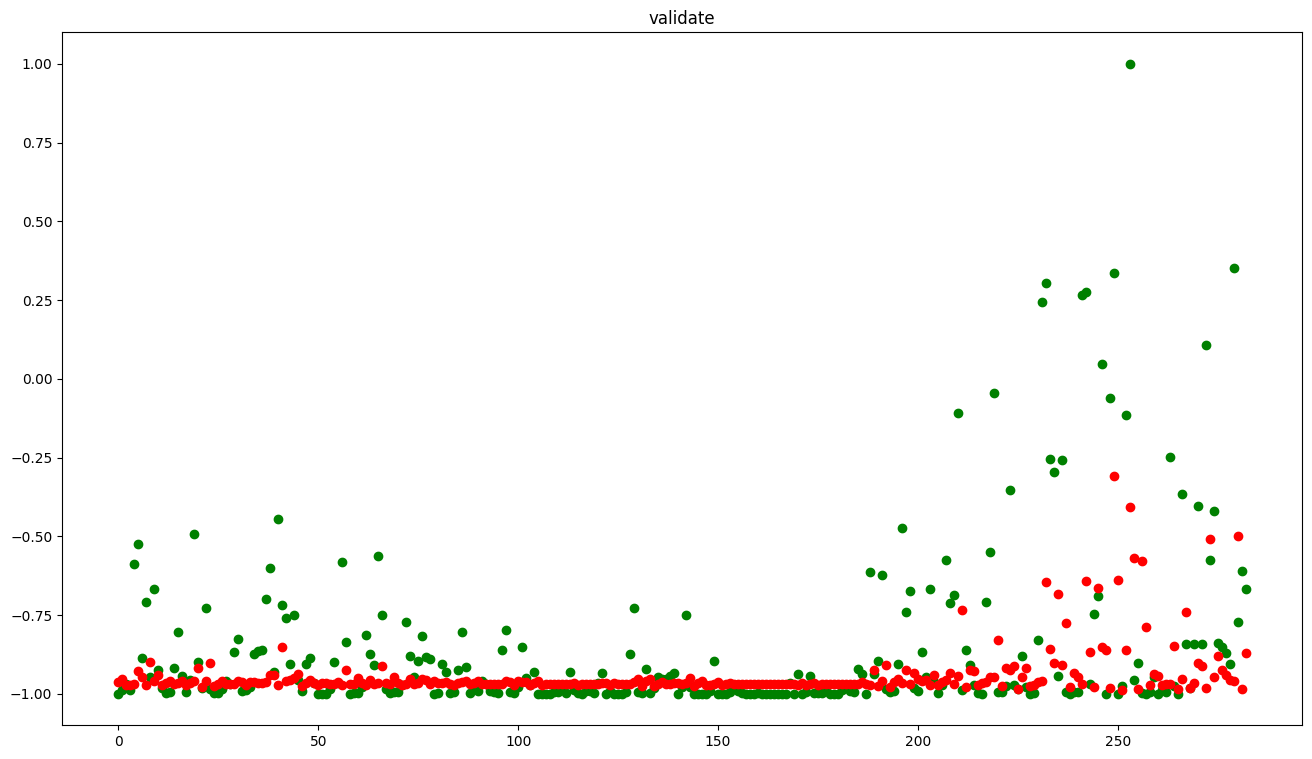

In [232]:
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

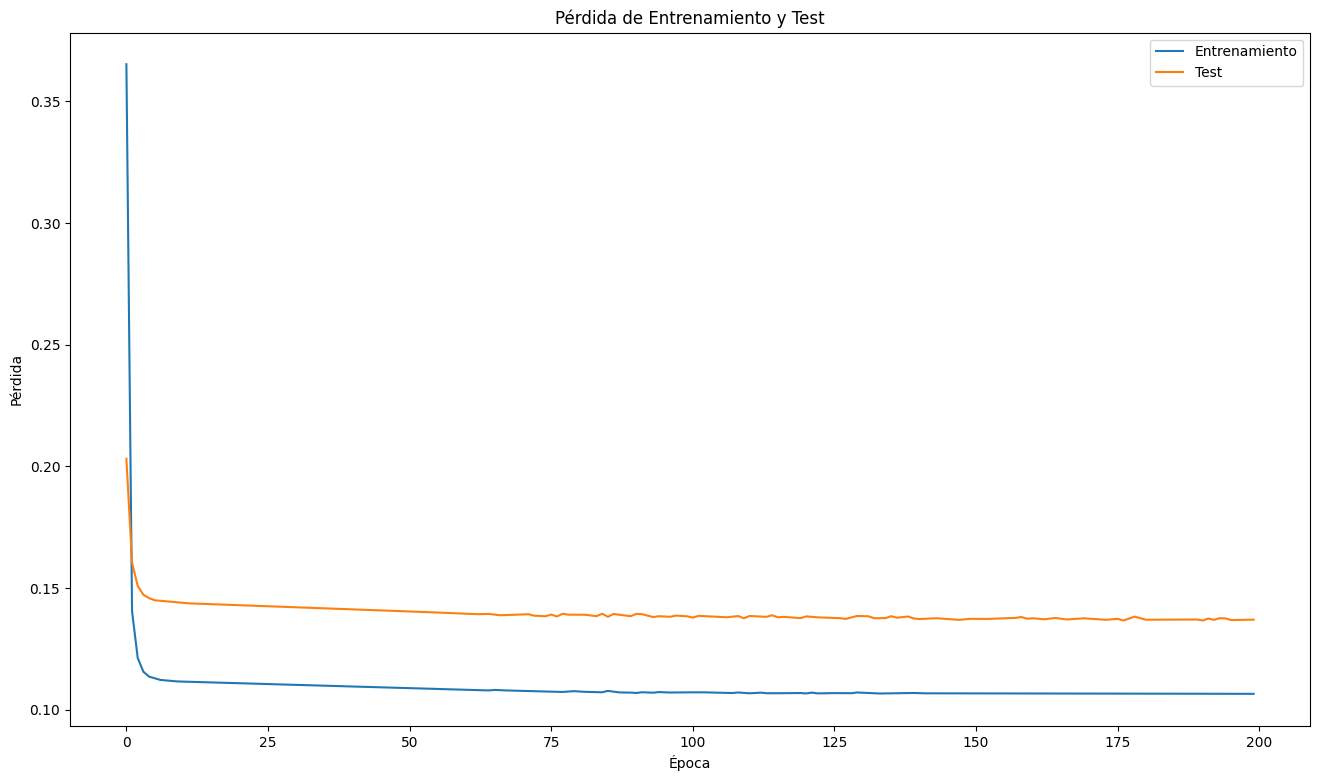

In [233]:
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Test')

# Etiquetas y título del gráfico
plt.title('Pérdida de Entrenamiento y Test')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()  # Muestra la leyenda con las etiquetas
plt.show()


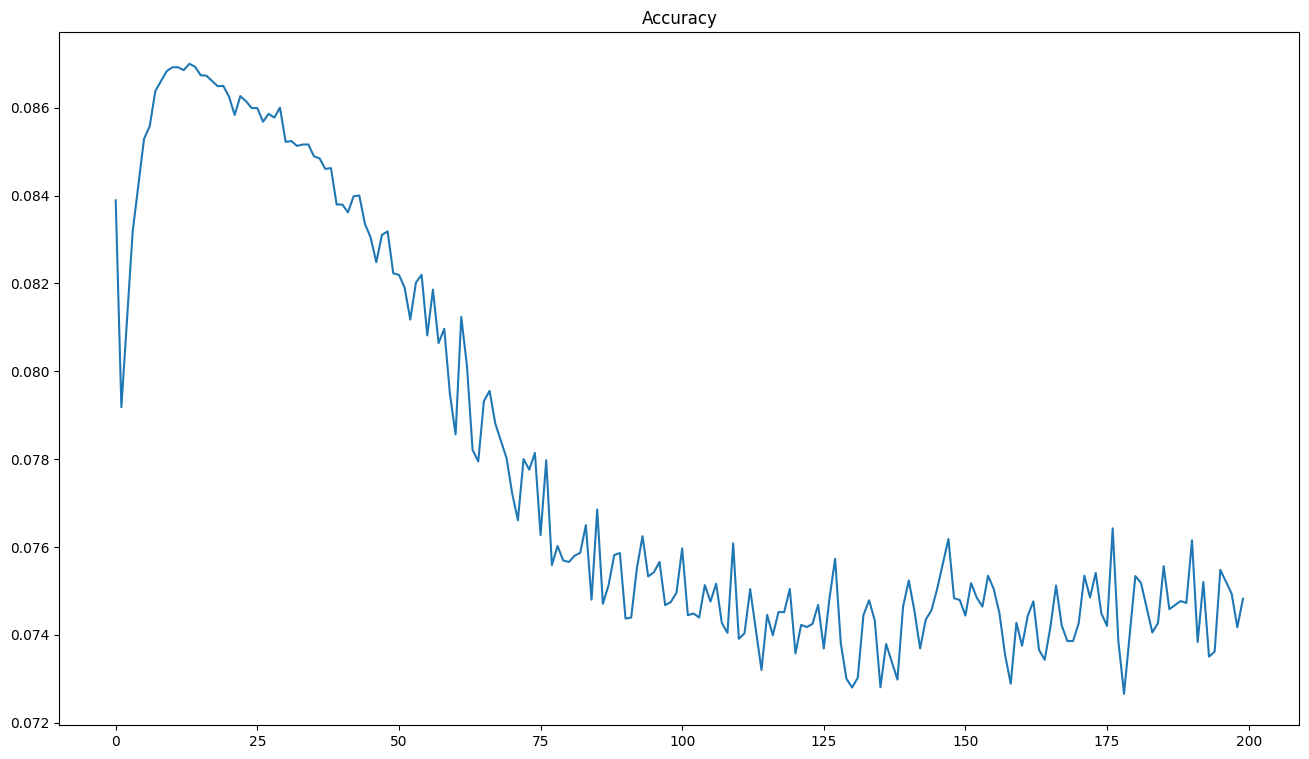

In [234]:
plt.title('Accuracy')
plt.plot(history.history['val_mse'])
plt.show()

In [235]:
import numpy as np
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(400)

,real,prediccion,diferencia
0,24.998638,11084.692383,-11059.693359
1,3704.999023,14186.215820,-10481.216797
2,8857.997070,8707.441406,150.555664
3,3616.992676,8484.357422,-4867.364746
4,122004.000000,9493.153320,112510.843750
...,...,...,...
278,27686.996094,12631.487305,15055.508789
279,399473.000000,12155.790039,387317.218750
280,67648.992188,147943.453125,-80294.460938
281,115542.007812,4851.674805,110690.335938


<Axes: >

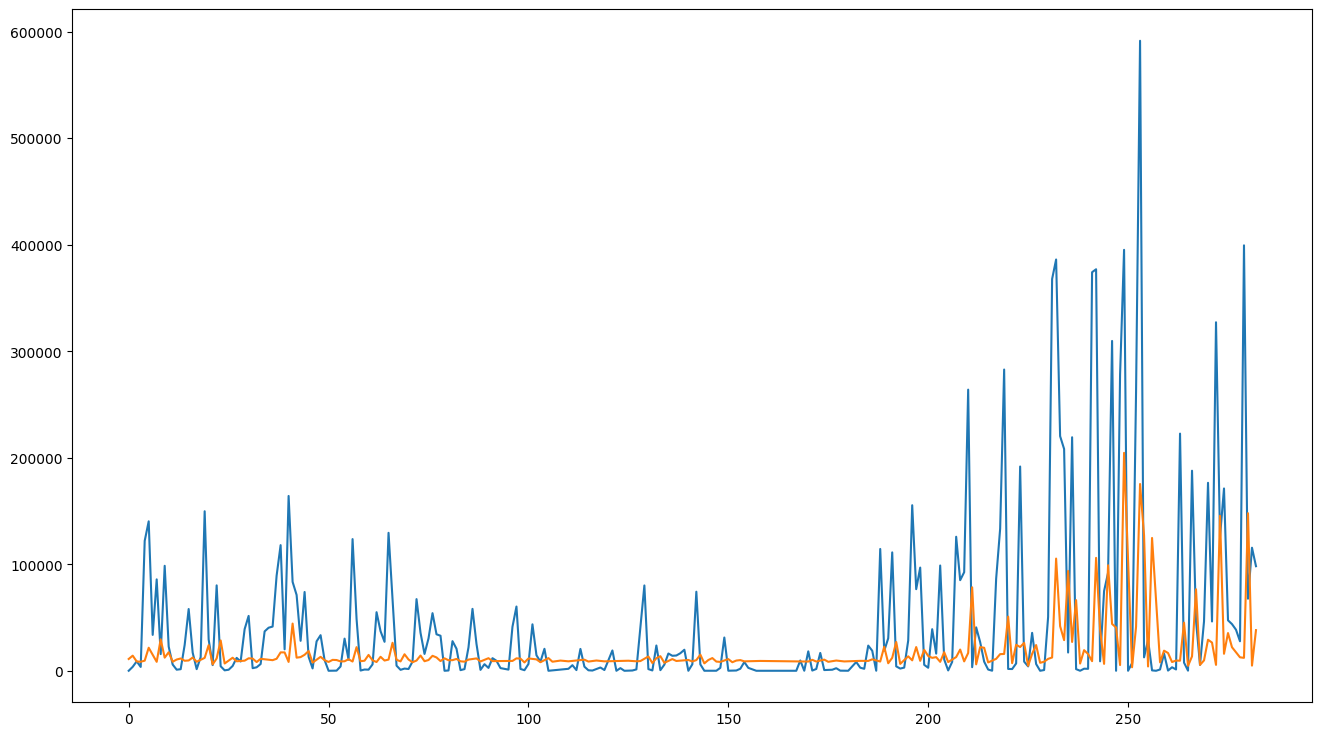

In [236]:
compara2['real'].plot()
compara2['prediccion'].plot()